# Long range dispersal model

This notebook simulates the evolution of a three-species system  with long-range dispersal, treating individuals as gas molecules with interactions occurring between any pair.

**Finite population size**

Let's consider a model world that has $N$ available sites. The sites are occupied by three species, namely species $r$ (rock), $s$ (scissors) and $p$ (paper), which occur in the proportions $n_r$ , $n_s$ and $n_p$ (with $n_r + n_s + n_p = 1$). Two sites are chosen at each time-step. The occupant of the first replicates into the second with a given probability - individual of species $r$ can invade a species $s$ with probability $P_r$, a species $s$ invades a species $p$ with probability $P_s$, a species $p$ invades a species $r$ with probability $P_p$ and all other invasion probabilities are zero. This dynamic may represent individuals competing for food: the winner consumes the food and gains enough resources to reproduce asexually, while the loser dies.

**Continuous-time model**

In the limit of large $N$, the rate of change of species population density is given by the mean-field equations:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)\\
\frac{\partial n_p}{\partial t}=n_p\cdot (n_r\cdot P_p - n_s \cdot P_s)\\
\end{cases}

where the system dynamic is approximated considering the average effect of interactions rather than tracking every specific interaction (hence the term mean-field).

For example, in the first equation, $n_s\cdot P_r$ represents the rate at which the rock species increases due to its successful invasion of the scissors species, while $n_p\cdot P_p$ represents the rate at which the rock species decreases due to the successful invasion of the paper species. The difference between these terms is then multiplied by the population density of the rock species to ensure that the rate of change is properly scaled according to the availability of species $r$. Similar considerations apply to the other equations.

Note that in these equations a unit of time $t$ is $N$ individual time-steps, which we refer to as an epoch.

**Fixed-point analysis**

Trivial fixed points of the system are ($n_r=0, n_s=0, n_p=1$), ($n_r=0, n_s=1, n_p=0$) and ($n_r=1, n_s=0, n_p=0$).

The non-trivial fixed point is obtained by setting the rates of change to zero:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)=0 \implies n_p = \frac{n_s\cdot P_r}{P_p}&\text{(1)}\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)=0 \implies n_r = \frac{n_p\cdot P_s}{P_r}&\text{(2)}\\
n_r+n_s+n_p=1 \implies n_s = 1-n_p-n_r&\text{(3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_r = \frac{n_s \cdot \cancel{P_r}\cdot P_s}{P_p\cdot \cancel{P_r}}&\text{(4), substituting (1) into (2)}\\
n_s = 1-\frac{n_s\cdot P_r}{P_p}-nr&\text{(5), substituting (1) into (3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_s=1-\frac{n_s\cdot P_r}{P_p}-\frac{n_s\cdot P_s}{P_p}\implies n_s=\frac{P_p}{P_p+P_r+P_s}&\text{(6), substituting (4) into (5)}\\
n_p=\frac{n_s\cdot P_r}{P_p}=\frac{\cancel{P_p}\cdot P_r}{\cancel{P_p}\cdot (P_p+P_r+P_s)}=\frac{P_r}{P_p+P_r+P_s}&\text{(7), substituting (6) into (1)}\\
n_r=\frac{n_p\cdot P_s}{P_r}=\frac{\cancel{P_r}\cdot P_s}{\cancel{P_r}\cdot (P_p+P_r+P_s)}=\frac{P_s}{P_p+P_r+P_s}&\text{(8), substituting (7) into (2)}\\
\end{cases}

In the following, we will refer to the population density at the fixed point as $R$, $S$ and $P$ for species $r$, $s$ and $p$ respectively.

The population densities at the fixed point are controlled by the invasion rate of the species they invade (the fixed point population of species $r$ depends on the invasion rate of species $s$, the fixed point population of species $s$ depends on the invasion rate of species $p$ and the fixed point population of species $p$ depends on the invasion rate of species $r$). As a consequence, the most aggressive species never has the highest fixed-point population. Moreover, if the invasion probabilities of two species are held steady, then a decrease in the competitive ability of the third leads to an increase in its fixed-point population. For example, if the invasion rate of species $p$ decreases, then the population at the fixed point of species $s$ decreases and since there are less $s$ individuals invading species $p$, the population of $p$ increases.

---

Importing the necessary libraries:

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colormaps
from scipy.integrate import odeint
from graphviz import Source
from sympy import symbols, Matrix, Eq, solve
np.random.seed(0)

## 1. Discrete-time model
### 1.1. Finite population size

Defining a function to simulate the evolution of the system for a world with $N$ sites:

In [2]:
def simulate_finite_N(Pr, Ps, Pp, nr_init, ns_init, N=1000, epochs=100):
    '''
    Simulate the evolution of a population of three species over time
    on a model world that has N available sites.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    N : int
        The number of sites.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if N < 1:
        raise ValueError('Number of sites must be at least 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    sites = numpy.zeros(N)

    nr = []
    ns = []
    np = []

    r_id = 1
    s_id = 2
    p_id = 3

    # Initialize the sites
    for i in range(N):
        sites[i] = numpy.random.choice([r_id, s_id, p_id], p=[nr_init, ns_init, 1-nr_init-ns_init])

    nr.append(numpy.sum(sites == r_id) / N)
    ns.append(numpy.sum(sites == s_id) / N)
    np.append(numpy.sum(sites == p_id) / N)

    for t in range(1, epochs):
        for step in range(N):
            # choose two random sites
            i = numpy.random.randint(0, N)
            j = numpy.random.randint(0, N)
            
            if sites[i] == r_id and sites[j] == s_id: # rock beats scissors
                if numpy.random.rand() < Pr:
                    sites[j] = r_id
            elif sites[i] == s_id and sites[j] == p_id: # scissors beats paper
                if numpy.random.rand() < Ps:
                    sites[j] = s_id
            elif sites[i] == p_id and sites[j] == r_id: # paper beats rock
                if numpy.random.rand() < Pp:
                    sites[j] = p_id
        
        nr.append(numpy.sum(sites == r_id) / N)
        ns.append(numpy.sum(sites == s_id) / N)
        np.append(numpy.sum(sites == p_id) / N)

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)
            ]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Defining functions to plot the evolution of the system:

In [3]:
def line_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a line plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    show_markers : bool
        Whether to show markers on the plot.
    '''
    ax = df.plot(
        figsize=(12, 4),
        style='o-' if show_markers else '-', color=['tab:red', 'purple', 'gold'],
        title=title,
        xlabel='Time'
    );
    if show_markers:
        for line in ax.get_lines():
            line.set_markeredgecolor('black')

def phase_plot_species_evolution(df, title=None):
    '''
    Plot the evolution of species proportions over time in a phase plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    cmap = colormaps['Blues']
    colors = cmap(np.linspace(0, 1, (df[df.columns[0]].shape[0]-1))) 
    for i in range(3):
        axs[i].plot(df[df.columns[i]][0:-1], df[df.columns[i]][1:], '-', color='k', zorder=1)
        axs[i].scatter(df[df.columns[i]][0:-1], df[df.columns[i]][1:], c=colors, s=50, zorder=2, edgecolor='black')
        axs[i].set_title(df.columns[i])
    fig.suptitle(title);
    fig.tight_layout()

def ternary_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a ternary plot.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    show_markers : bool
        Whether to show markers on the plot.
    '''
    fig = px.scatter_ternary(
        df,
        a=df.columns[2],
        b=df.columns[0],
        c=df.columns[1],
        color=df.index,
        color_continuous_scale='blues',
        size_max=10,
        title=title
    )
    if show_markers:
        fig.update_traces(mode='lines+markers', line=dict(color='black', width=1),
            marker=dict(symbol='circle', line=dict(width=1, color='black')))
    else:
        fig.update_traces(mode='lines', line=dict(color='black', width=1))
    fig.update_layout(coloraxis_colorbar=dict(title='Time'))
    fig.show('png')

Simulating the evolution of the system with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, $N = 1000$, initialized with population densities closed to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [4]:
finite_N_df = simulate_finite_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, N=1000, epochs=1000)

Plotting the evolution of the system:

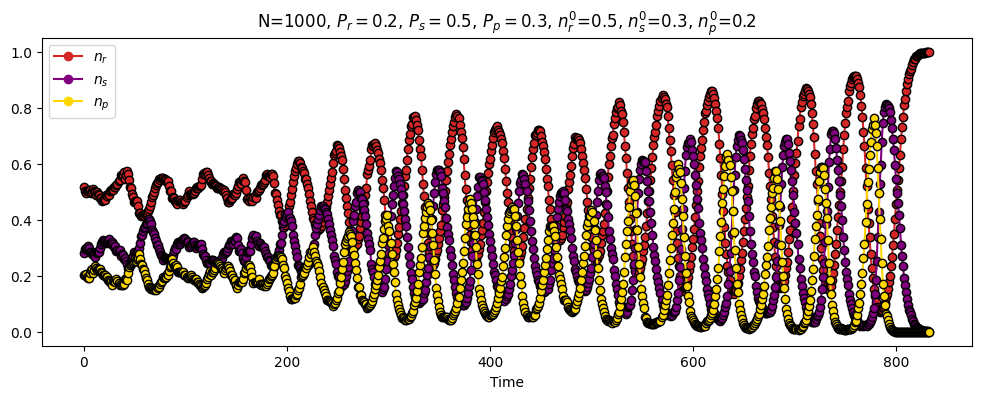

In [5]:
line_plot_species_evolution(
    finite_N_df,
    title='N=1000, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3, $n_p^0$=0.2'
)

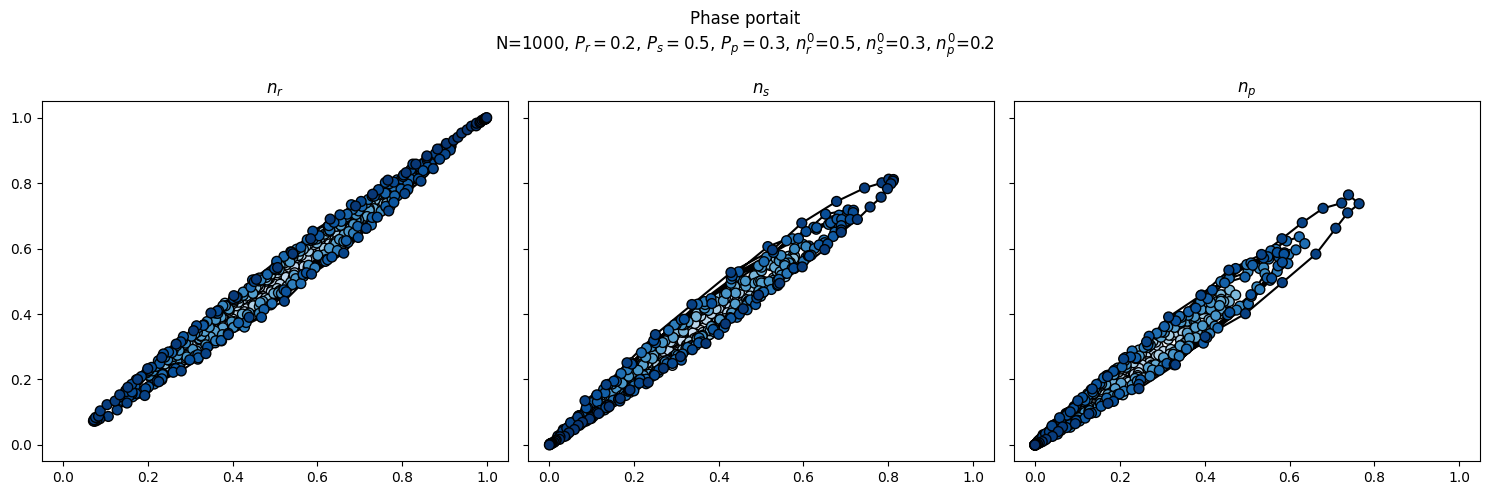

In [6]:
phase_plot_species_evolution(
    finite_N_df,
    title='Phase portait\nN=1000, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3, $n_p^0$=0.2'
)

Replicating Figure 1b from [[1]](#6-references):

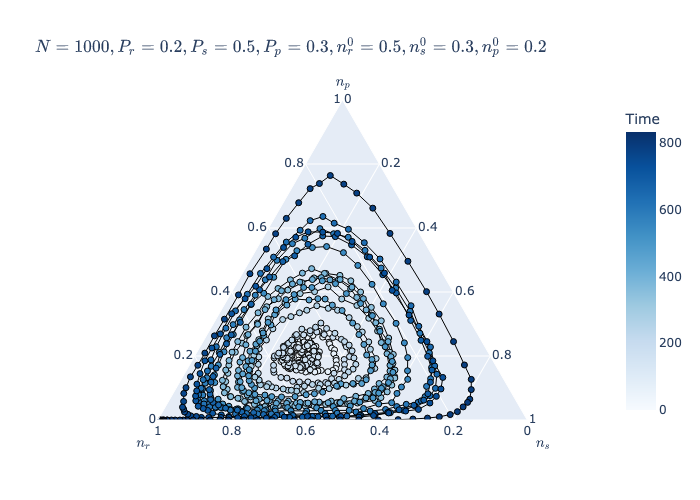

In [7]:
ternary_plot_species_evolution(
    finite_N_df,
    title=r"$N=1000, P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=0.5, n_s^0=0.3, n_p^0=0.2$"
)

In a finite world, the populations oscillate with increasing amplitude, with two species (scissors and paper) eventually becoming extinct. The species that survives (rock) is the one that has the lowest invasion rate.

Performing simulations for a range of invasion probabilities chosen to sum to unity, initializing the population densities close to the fixed point and recording the surviving species (replicating Figure 1c from [[1]](#6-references)):

In [8]:
# defining a grid of points for invasion probabilities
R, S = np.mgrid[0:1:20j, 0:1:20j]
R, S = R.ravel(), S.ravel()
P = 1 - R - S
I = np.array([R, S, P]).T
# keeping only invasion probabilities greater than 0.01
I = I[np.all(I > 0.01, axis=1)]
R = I[:, 0]
S = I[:, 1]
P = I[:, 2]
# total number of simulations to run
num_sim = len(I)
# number of sites 
N = 1000
# maximum number of iterations
EPOCHS = 2000
# list to store the winner of each simulation
winners = []

# iterating over the invasion probabilities
for i, (Pr, Ps, Pp) in enumerate(I):
    print(f"[{i+1}/{num_sim}] Running simulation for invasion probabilities: Pr={Pr:.2f}, Ps={Ps:.2f}, Pp={Pp:.2f}")
    # simulating with the current invasion probabilities
    results_df = simulate_finite_N(
        Pr=Pr, Ps=Ps, Pp=Pp,
        nr_init=Ps, ns_init=Pp,
        N=N, epochs=EPOCHS
    )
    # storing the winner
    if results_df.index.stop==EPOCHS: # no winner
        winners.append('None')
    elif np.isclose(results_df.iloc[-1]['$n_r$'], 1, 1e-4): # rock wins
            winners.append('Rock')
    elif np.isclose(results_df.iloc[-1]['$n_s$'], 1, 1e-4): # scissors wins
        winners.append('Scissors')
    else: # paper wins
        winners.append('Paper')

[1/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.05, Pp=0.89
[2/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.11, Pp=0.84
[3/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.16, Pp=0.79
[4/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.21, Pp=0.74
[5/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.26, Pp=0.68
[6/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.32, Pp=0.63
[7/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.37, Pp=0.58
[8/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.42, Pp=0.53
[9/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.47, Pp=0.47
[10/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.53, Pp=0.42
[11/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.58, Pp=0.37
[12/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.63, Pp=0.32
[13/153] Running simulati

Plotting the surviving species on a ternary plot:

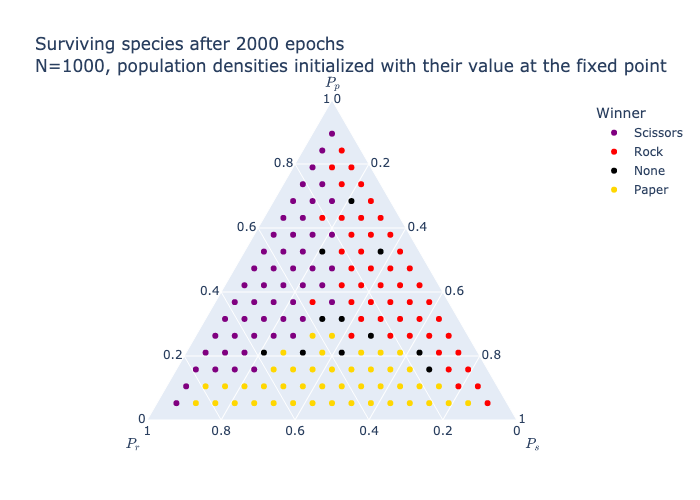

In [9]:
fig = px.scatter_ternary(
    pd.DataFrame(I, columns=['$P_r$', '$P_s$', '$P_p$']),
    a="$P_p$",
    b="$P_r$",
    c="$P_s$",
    size_max=10,
    title=f"Surviving species after {EPOCHS} epochs<br>N={N}, population densities initialized with their value at the fixed point",
    color = winners,
    color_discrete_map={'None': 'black', 'Rock': 'red', 'Scissors': 'purple', 'Paper': 'gold'}
    )
fig.update_layout(legend_title_text='Winner')
fig.show('png')

The weakest competitor is most likely to survive.

### 1.2. Large population size

To transform the differential equations describing the system under the large $N$ assumption into discrete-time recurrence relations, we approximate the derivative $\frac{\partial n_r}{\partial t}$ by the difference between the population densities at consecutive time steps

$$\frac{\partial n_r}{\partial t}=\frac{n_r[t+1]-n_r[t]}{\Delta_t}$$

and we solve for $n_r[t+1]$, obtaining

$$n_r[t+\Delta_t]=n_r[t] + \Delta_t \cdot n_r[t](n_s[t]P_r - n_p[t] P_p)$$

Applying the same reasoning to the other equations, we obtain the following system of recurrence equations:

\begin{cases}
n_r[t+\Delta_t]=n_r[t] + \Delta_t \cdot n_r[t](n_s[t]P_r - n_p[t] P_p)\\
n_s[t+\Delta_t]=n_s[t] + \Delta_t \cdot n_s[t](n_p[t]P_s - n_r[t] P_r)\\
n_p[t+\Delta_t]=n_p[t] + \Delta_t \cdot n_p[t](n_r[t]P_p - n_s[t] P_s)\\
\end{cases}

Defining a function to simulate the evolution of the system of recurrent equations under the large $N$ assumption:

In [10]:
def simulate_large_N(Pr, Ps, Pp, nr_init, ns_init, delta_t=0.001, epochs=1000):
    '''
    Simulate the evolution of a population of three species over time using 
    the recurrence relations under the large N assumption.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    delta_t : float
        The time step size.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    nr = []
    ns = []
    np = []

    nr.append(nr_init)
    ns.append(ns_init)
    np.append(1 - nr_init - ns_init)

    for _ in range(0, epochs-1):
        nr.append(nr[-1] + nr[-1]*delta_t*(ns[-1]*Pr - np[-1]*Pp))
        ns.append(ns[-1] + ns[-1]*delta_t*(np[-1]*Ps - nr[-2]*Pr)) # use nr from the previous time step
        np.append(1 - nr[-1] - ns[-1])

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Simulating the evolution of the system of recurrent equations under the large $N$ assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [11]:
fp_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, epochs=100)

Plotting the evolution of the system:

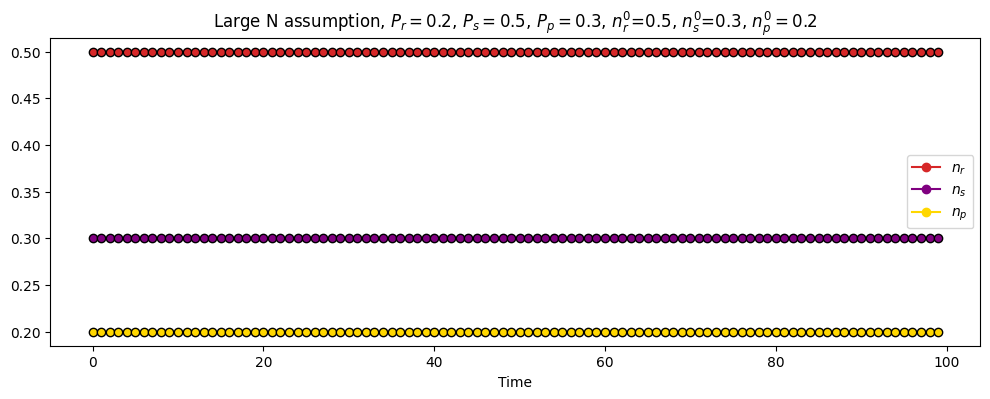

In [12]:
line_plot_species_evolution(
    fp_large_N_df,
    title='Large N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3, $n_p^0=0.2$'
)

By initializing the population densities equal to the fixed point, the system remains at the fixed point.

Simulating the evolution of the system under the large $N$ assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$) and using $\Delta_t=1$:

In [13]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=1, epochs=1000)

Plotting the evolution of the system:

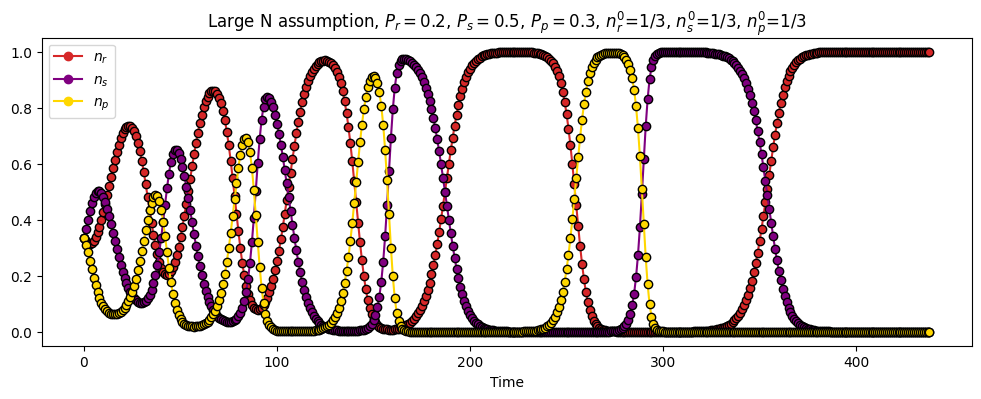

In [14]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Large N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3, $n_p^0$=1/3'
)

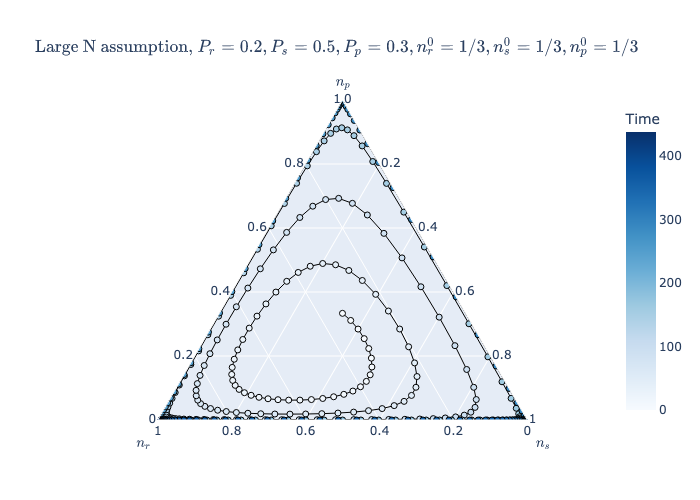

In [15]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Large N assumption, }P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3, n_p^0=1/3$"
)

Simulating the evolution of the system with $\Delta_t=0.01$ to increase accuracy:

In [16]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=0.01, epochs=100000)

Plotting the evolution of the system:

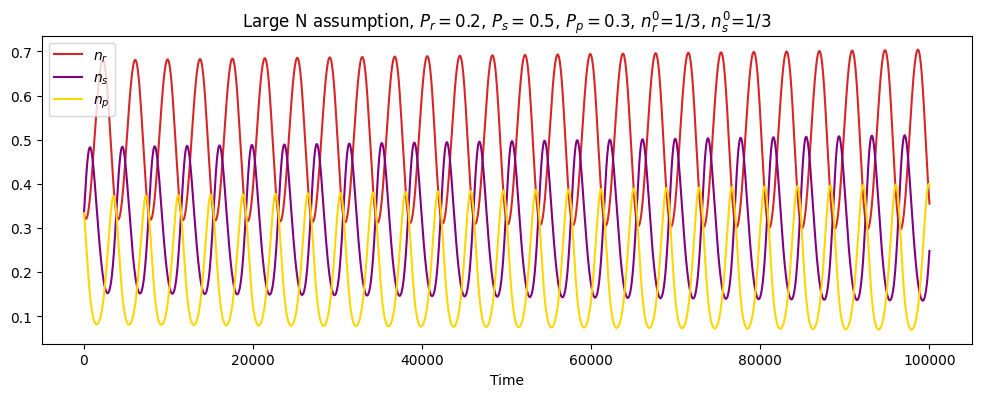

In [17]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Large N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3',
    show_markers=False
)

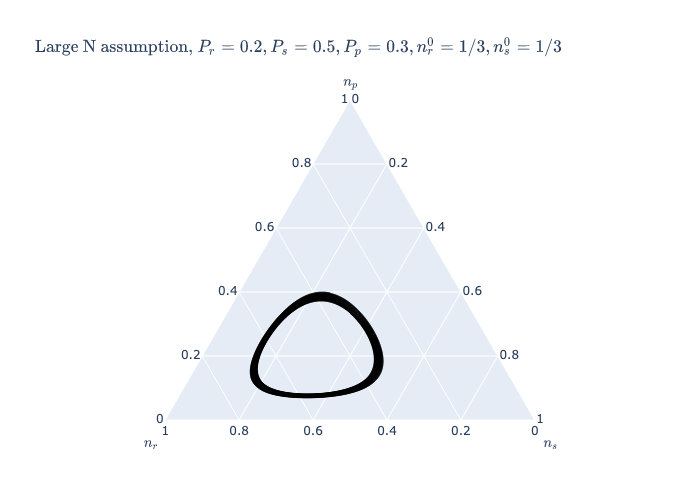

In [18]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Large N assumption, }P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3$",
    show_markers=False
)

In the limit that the total number of sites is large, the populations exhibit sustained oscillations, moving along a periodic orbit around the fixed point.

## 2. Continuous-time model

To enhance accuracy, we simulate the system's evolution by solving the differential equations that define it.

The [`odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) method from `scipy.integrate` solves a system of ordinary differential equations using lsoda from the FORTRAN library odepack. This library uses the Adams/BDF method with automatic stiffness detection.

In [19]:
def ODE_solver(t, P, x0):
    '''
    Solve the initial value problem for the ODE system.
    '''
    def RSP(x, t, P):
        nr = x[0]
        Pr = P[0]
        ns = x[1]
        Ps = P[1]
        np = 1 - nr - ns
        Pp = P[2]

        d_nr_dt = nr*(ns*Pr - np*Pp)
        d_ns_dt = ns*(np*Ps - nr*Pr)
        return [d_nr_dt, d_ns_dt]

    y = odeint(RSP, x0, t, args=(P,))
    results_df = pd.DataFrame(y, columns=['$n_r$', '$n_s$'])
    results_df['$n_p$'] = 1 - results_df['$n_r$'] - results_df['$n_s$']
    return results_df

def simulate_continuous(t, Pr, Ps, Pp, nr_init, ns_init):
    '''
    Simulate the evolution of a population of three species over time in the
    continuous setting, solving the initial value problem for the ODE system.
    '''
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('P_r, P_s and P_p must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)

    P = [Pr, Ps, Pp]
    x0 = [nr_init, ns_init]
    s = ODE_solver(t, P, x0)
    return s

Simulating the evolution of the system in the continuous setting with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [20]:
fp_continuous_df = simulate_continuous(t=np.linspace(0,100,101), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3)

Plotting the evolution of the system:

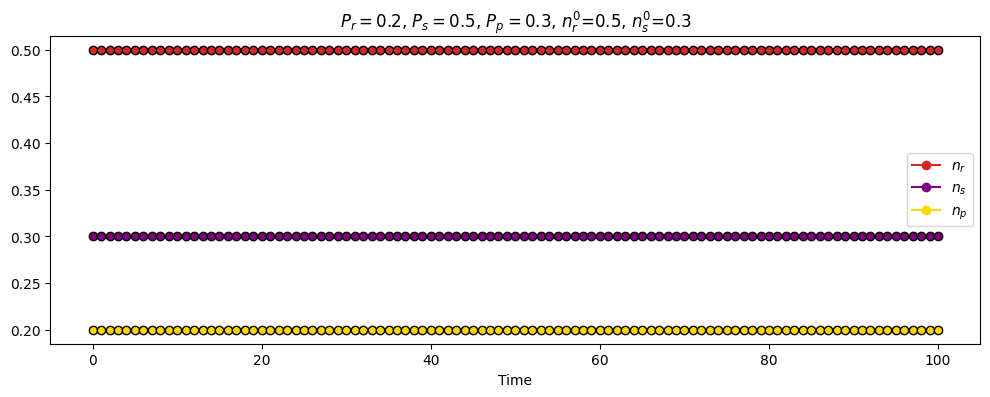

In [21]:
line_plot_species_evolution(
    fp_continuous_df,
    title='$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3'
)

As in the discrete time setting, by initializing the population densities equal to the fixed point, the system remains at the fixed point.

Simulating the evolution of the system in the continuous setting with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$):

In [22]:
eq_continuous_df = simulate_continuous(t=np.linspace(0,1000,1001), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3)

Plottting the evolution of the system:

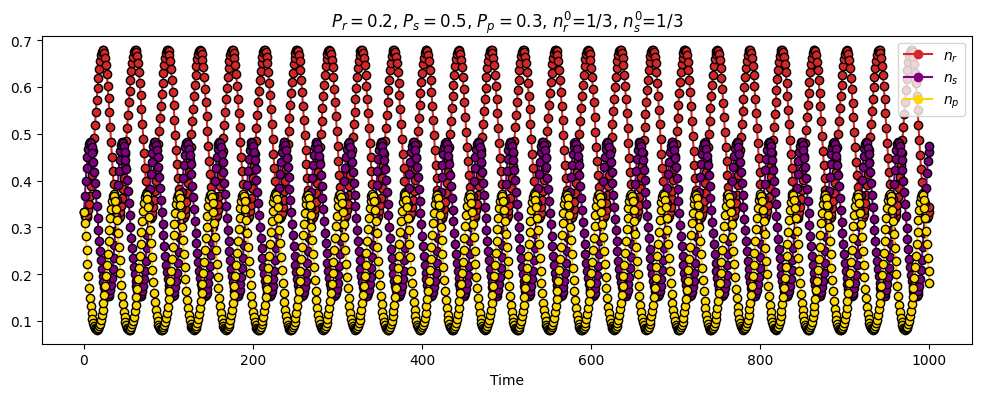

In [23]:
line_plot_species_evolution(
    eq_continuous_df,
    title='$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3'
)

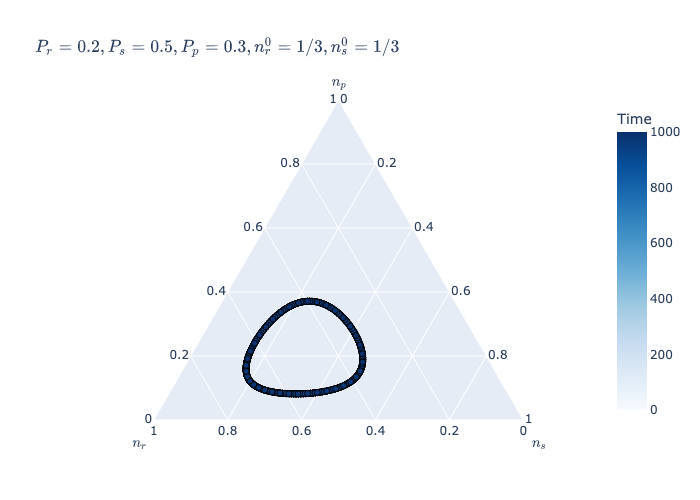

In [24]:
ternary_plot_species_evolution(
    eq_continuous_df,
    title=r"$P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3$"
)

Again, the populations move along a periodic orbit around the fixed point.

Performing simulations for different initial population densities and plotting the orbits on a ternary plot (replicating Figure 1a from [[1]](#6-references)):

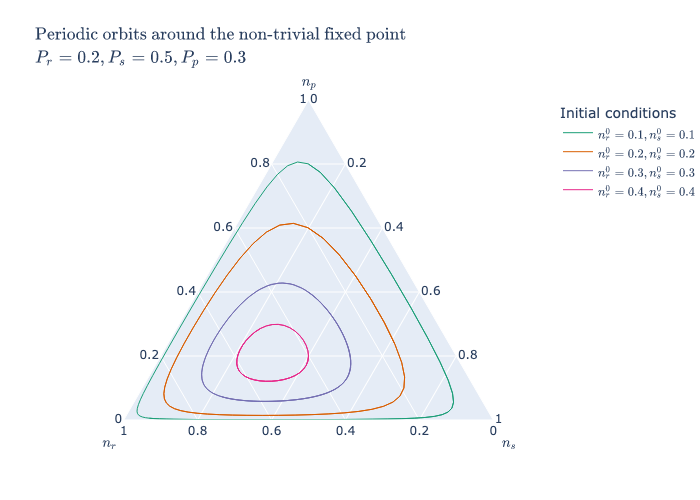

In [25]:
fig = go.Figure()
# iterating over initial proportions
for i, init in enumerate([0.1, 0.2, 0.3, 0.4]):
    # simulate the system
    df = simulate_continuous(t=np.linspace(0,100,101), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=init, ns_init=init)
    # plot the trajectory
    fig.add_trace(go.Scatterternary(
        mode='lines',
        a=df['$n_p$'],
        b=df['$n_r$'],
        c=df['$n_s$'],
        name=f'$n_r^0={init}, n_s^0={init}$',
        line=dict(color=px.colors.qualitative.Dark2[i], width=1)
    ))
fig.update_layout(
    ternary=dict(
        aaxis_title='$n_p$',
        baxis_title='$n_r$',
        caxis_title='$n_s$'
    ),
    title=r"$\text{Periodic orbits around the non-trivial fixed point}\\P_r=0.2, P_s=0.5, P_p=0.3$",
    legend=dict(
        title='Initial conditions'
    )
)
fig.show('png')

The quantity $\lambda=(\frac{n_r}{R})^R(\frac{n_s}{S})^S(\frac{n_p}{P})^P$ is invariant along each orbit, with $\lambda=1$ when the populations are at the fixed point and $\lambda=0$ when one or more of the species become extinct [[2]](#6-references). 

Defining a function to calculate the invariant:

In [26]:
def compute_lambda(df, Pr, Ps, Pp):
    df['lambda'] = (df['$n_r$']/0.5)**Ps*(df['$n_s$']/Pp)**Pp*(df['$n_p$']/Pr)**Pr
    return df

Computing and plotting the orbit invariant:

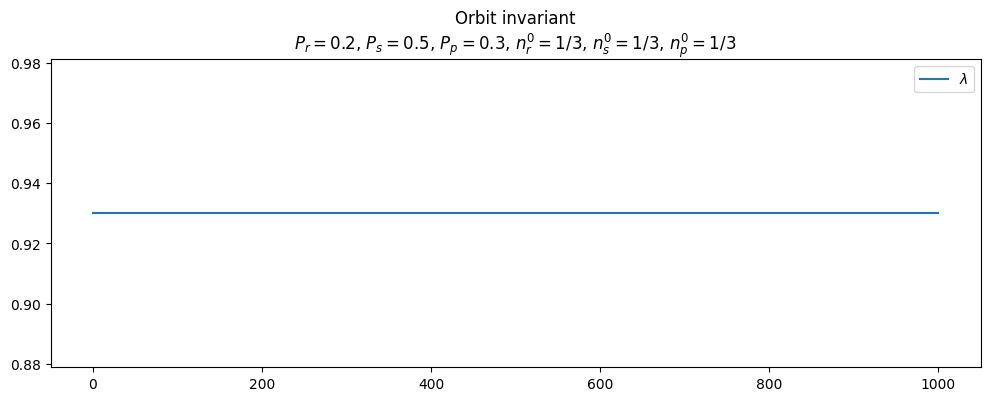

In [27]:
eq_continuous_df = compute_lambda(eq_continuous_df, Pr=0.2, Ps=0.5, Pp=0.3)
eq_continuous_df['lambda'].apply(lambda x: round(x, 2)).plot(
    figsize=(12,4),
    y='lambda',
    style='-', label='$\lambda$',
    title='Orbit invariant\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0=1/3$, $n_s^0=1/3$, $n_p^0=1/3$'
)
plt.legend()

## 3. Stochastic simulation of chemical reactions

While ODEs are deterministic and do not account for fluctuations in population densities, stochastic simulation methods offer greater accuracy, particularly when analyzing reaction systems with small quantities of molecules. Furthermore, unlike discrete time simulations, stochastic simulations use an exponential probability distribution to model the time between subsequent occurrences of an event.

To perform stochastic simulations, we need to translate the ODE system

\begin{cases}
\frac{\partial n_r}{\partial t}=\textcolor{violet}{n_r\cdot n_s\cdot P_r} - \textcolor{gold}{n_r \cdot n_p \cdot P_p}\\
\frac{\partial n_s}{\partial t}=\textcolor{cyan}{n_s\cdot n_p\cdot P_s} - \textcolor{orange}{n_s\cdot n_r \cdot P_r}\\
\frac{\partial n_p}{\partial t}=\textcolor{palegreen}{n_p\cdot n_r\cdot P_p} - \textcolor{red}{n_p\cdot n_s \cdot P_s}\\
\end{cases}

into a system of chemical reactions, by constructing one reaction for each term of the equations as follows

\begin{cases}
\textcolor{violet}{R + S \xrightarrow{P_r} S + 2R}\\
\textcolor{gold}{R + P \xrightarrow{P_p} P}\\
\textcolor{cyan}{S + P \xrightarrow{P_s} P + 2S}\\
\textcolor{orange}{S + R \xrightarrow{P_r} R}\\
\textcolor{palegreen}{P + R \xrightarrow{P_p} R + 2P}\\
\textcolor{red}{P + S \xrightarrow{P_s} S}\\
\end{cases}

where we use the capital letters $R, S, P$ to denote the species rock, scissors and paper respectively.

We can simplify the system by noting, for example, that the terms $\textcolor{violet}{n_r\cdot n_s\cdot P_r}$ and $\textcolor{orange}{n_s\cdot n_r \cdot P_r}$ can be represented by the same reaction (i.e., when an $R$ individual wins, it reproduces while the losing $S$ individual dies). Thus, we can combine these into a single reaction and apply the same process to similar terms, resulting in the following system:

\begin{cases}
R + S \xrightarrow{P_r} 2R\\
S + P \xrightarrow{P_s} 2S\\
P + R \xrightarrow{P_p} 2P\\
\end{cases}

We will use [`StochPy`](https://stochpy.sourceforge.net), a Python package for stochastic simulation of chemical reactions:

In [28]:
import stochpy


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

To describe a system of chemical reaction, StochPy uses the [PySCeS MDL](https://stochpy.sourceforge.net/html/inputfile_doc.html#pysces-inputfile), an ASCII text based input file. We defined the system using such format and saved it in the file `../long_range_models/RSP_model_reduced.psc`:

In [29]:
!cat ../long_range_models/RSP_model_reduced.psc

# Rock Scissors Paper model

# R + S  --> 2R, Pr
# P + R --> 2P, Pp
# S + P --> 2S, Ps

R1:
    R + S > R + R
    R*S*Pr

R2:
    S + P > S + S
    S*P*Ps

R3: 
    P + R > P + P
    P*R*Pp

# Parameters
Pr = 0.2
Ps = 0.5
Pp = 0.3

# Init Values
R = 33
S = 33
P = 33


Loading the model:

In [30]:
smod = stochpy.SSA(IsQuiet=False)
smod.Model(model_file="RSP_model_reduced.psc",dir="../long_range_models/")
smod.ShowSpecies()

Info: Direct method is selected to perform stochastic simulations.
Parsing file: /Users/irenetesta/Stochpy/pscmodels/ImmigrationDeath.psc
Info: No reagents have been fixed
Parsing file: ../long_range_models/RSP_model_reduced.psc
Info: No reagents have been fixed
['R', 'S', 'P']


Setting initial conditions (close to the fixed point) and parameters, using a high number of copies for each species to approximate the deterministic behavior of the system:

In [31]:
smod.ChangeParameter("Pr", 0.2)
smod.ChangeParameter("Ps", 0.5)
smod.ChangeParameter("Pp", 0.3)
smod.ChangeInitialSpeciesCopyNumber("R", 50000)
smod.ChangeInitialSpeciesCopyNumber("S", 30000)
smod.ChangeInitialSpeciesCopyNumber("P", 20000)

The method to perform a stochastic simulation is `DoStochSim`:

In [32]:
help(smod.DoStochSim)

Help on method DoStochSim in module stochpy.modules.StochSim:

DoStochSim(end=False, mode=False, method=False, trajectories=False, epsilon=0.03, IsTrackPropensities=False, rate_selection=None, species_selection=None, IsOnlyLastTimepoint=False, critical_reactions=[], reaction_orders=False, species_HORs=False, species_max_influence=False, quiet=False) method of stochpy.modules.StochSim.SSA instance
    Run a stochastic simulation for until `end` is reached. This can be either time steps or end time (which could be a *HUGE* number of steps).
    
    Input:
     - *end* [default=1000] (float) simulation end (steps or time)
     - *mode* [default='steps'] (string) simulation mode, can be one of: ['steps','time']
     - *method* [default='Direct'] (string) stochastic algorithm ['Direct', 'FRM', 'NRM', 'TauLeap']
     - *trajectories* [default = 1] (integer)
     - *epsilon* [default = 0.03] (float) parameter for the tau-leap method
     - *IsTrackPropensities* [default = False]
     - *rate

In the following, we will only use the Direct method as its variants are designed to reduce computational costs, which is not a concern for the simulations we will perform.

Performing a stochastic simulation using default parameters:

Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 1000 End time 1.0951329075756742e-06
Info: Simulation time 0.00992


/Users/irenetesta/anaconda3/envs/try/lib/python3.11/site-packages/stochpy/modules/Analysis.py:479: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.



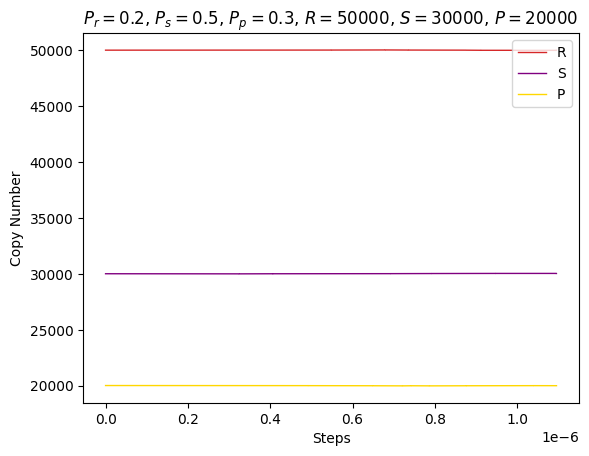

In [33]:
smod.DoStochSim()
smod.PlotSpeciesTimeSeries(colors=["tab:red", "purple", "gold"], xlabel="Steps")
stochpy.plt.title("$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50000$, $S=30000$, $P=20000$");

As in deterministic simulations, using a high number of molecules and initializing species copy number close to the fixed point, ensures that the system remains at the fixed point.

Performing a stochastic simulation with a lower number of molecules and tracking reaction propensities:

In [34]:
smod.ChangeInitialSpeciesCopyNumber("R", 50)
smod.ChangeInitialSpeciesCopyNumber("S", 30)
smod.ChangeInitialSpeciesCopyNumber("P", 20)
smod.DoStochSim(end=10000, IsTrackPropensities=True)
fp_stoch_df = pd.DataFrame(smod.data_stochsim.species, columns=['R', 'S', 'P'])

Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 1928 End time 2.519492477708811
Info: Simulation time 0.05302


Plotting the evolution of the system:

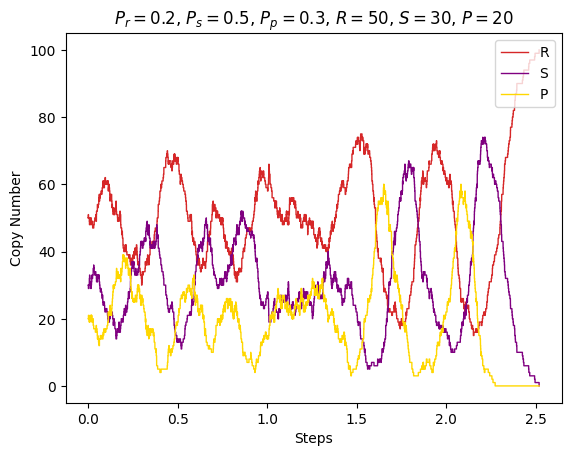

In [35]:
smod.PlotSpeciesTimeSeries(colors=["tab:red", "purple", "gold"], xlabel="Steps")
stochpy.plt.title("$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$");

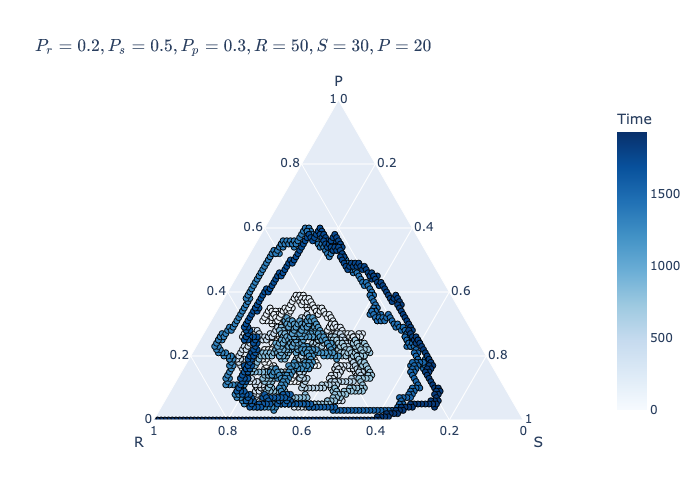

In [36]:
ternary_plot_species_evolution(
    fp_stoch_df,
    title=r"$P_r=0.2, P_s=0.5, P_p=0.3, R=50, S=30, P=20$",
)

With fewer molecules, two species (scissors and paper) eventually become extinct, and the species that survives (rock) is the one that has the lowest invasion rate, similarly to the discrete-time model with a finite number of sites.

Visualizing reaction propensities:

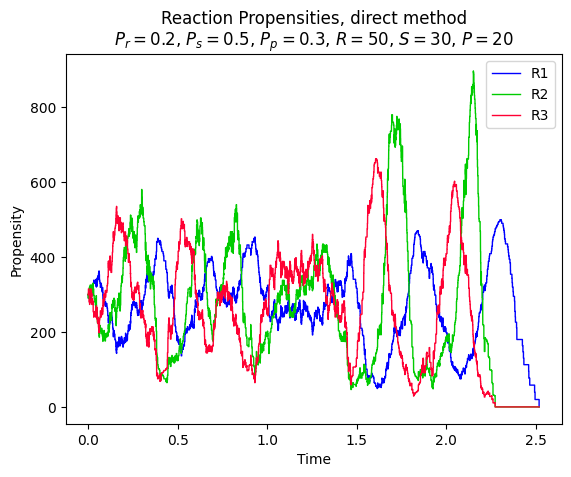

In [37]:
smod.PlotPropensitiesTimeSeries(title='Reaction Propensities, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$')

At $t=0$, $R1$ propensity is $R\cdot S\cdot P_r=50\cdot 30\cdot 0.2=300$, $R2$ propensity is $S\cdot P\cdot P_s=30\cdot 20\cdot 0.5=300$ and $R3$ propensity is $P\cdot R\cdot P_p=20\cdot 50\cdot 0.3=300$, where $R,S,P$ denote the number of molecules of each species. The propensities of the reactions are equal, which is expected as the system is at the fixed point. However, due to the stochastic nature of the model, the system quickly deviates from this point.

Plotting the time between two subsequent firings of a reaction:

Reaction	Mean
R1	0.004
R2	0.004
R3	0.004


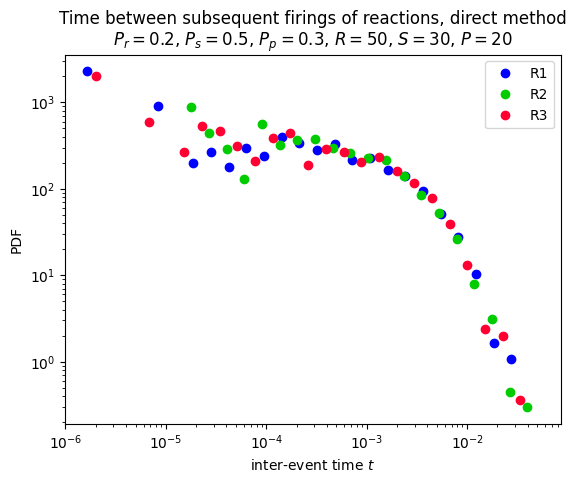

In [38]:
smod.PlotWaitingtimesDistributions(title='Time between subsequent firings of reactions, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$')
smod.PrintWaitingtimesMeans()

The three reactions have the same average time between two subsequent firings. $R2$ waiting times are longer than $R1$ and $R3$ because the number of molecules of species $S$ and $P$ is lower than the number of molecules of species $R$.

To approximate the deterministic behavior we can either perform multiple stochastic simulations and average the species copy numbers at each time point:

Info: 100 trajectories are generated
Info: Time simulation output of the trajectories is stored at RSP_model_reduced(trajectory).dat in directory: /Users/irenetesta/Stochpy/temp
Info: Simulation time: 0.14871883392333984                                                   

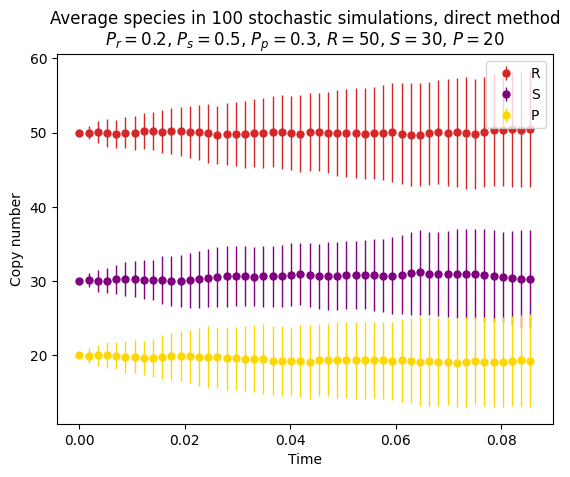

In [39]:
smod.DoStochSim(end=100, trajectories=100)
smod.GetRegularGrid(n_samples=50)
smod.PlotAverageSpeciesTimeSeries(
    colors=["tab:red", "purple", "gold"],
    title="Average species in 100 stochastic simulations, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$")

To get an accurate prediction of the species distribution StochPy provides the function `DoCompleteStochSim()` that continues the simulation until the first four moments converge within a user-specified error (default = 0.001):

Info: 100000 time steps simulated
Info: 200000 time steps simulated
Info: 300000 time steps simulated
Info: 400000 time steps simulated
Info: 500000 time steps simulated
Info: 600000 time steps simulated
Info: 700000 time steps simulated
Info: 800000 time steps simulated
Info: 900000 time steps simulated
Info: 1000000 time steps simulated
Info: 1100000 time steps simulated
Info: 1200000 time steps simulated
Info: 1300000 time steps simulated
Info: 1400000 time steps simulated
Info: 1500000 time steps simulated
Info: 1600000 time steps simulated
Info: 1700000 time steps simulated
Info: 1800000 time steps simulated
Info: 1900000 time steps simulated
Info: 2000000 time steps simulated
Info: 2100000 time steps simulated
Info: 2200000 time steps simulated
Info: 2300000 time steps simulated
Info: 2400000 time steps simulated
Info: 2500000 time steps simulated
Info: 2600000 time steps simulated
Info: 2700000 time steps simulated
Info: 2800000 time steps simulated
Info: 2900000 time steps simu

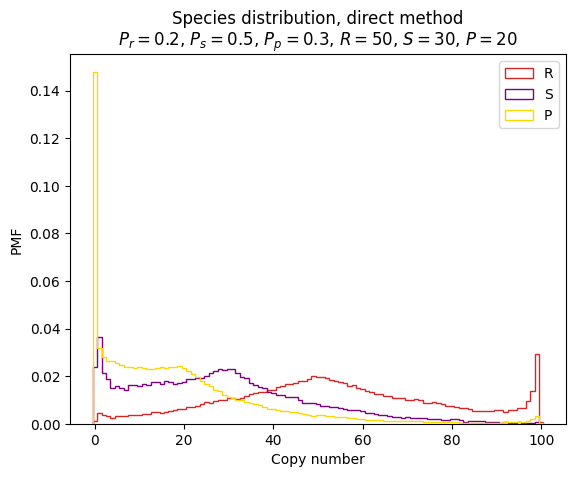

In [40]:
smod.DoCompleteStochSim()
smod.PlotSpeciesDistributions(
    colors=["tab:red", "purple", "gold"],
    title="Species distribution, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$")

Species $R$ probability mass is concentrated at lower values, while species $R$ and $S$ have a more uniform distribution.

Computing mean and standard deviation of the species copy number is not straightforward as the time between two events is not constant, thus it is necessary to track the time spent in each state for each species. This computation is implemented by the following functions:

In [41]:
smod.PrintSpeciesMeans()
smod.PrintSpeciesStandardDeviations()

Species	Mean
R	53.108
S	28.366
P	18.526
Species	Standard Deviation
R	23.734
S	19.751
P	18.520


Species mean copy number is close to the fixed point.

We can also experiment with delayed reactions, consisting of an exponential waiting time as initiation step with a subsequent delay time.
We set a fixed delay of five seconds on reaction $R1$ ($R + S \rightarrow 2R$). This means that after $R1$ fires, it takes exactly five seconds before products are produced. By setting `nonconsuming_reactions=["R1"]`, reactants are consumed at completion.

*** WARNING ***: an invalid method (Direct) was selected. Switching to the Delayed Direct Method.
Info: Delayed Direct Method is selected to perform delayed stochastic simulations.
Parsing file: ../long_range_models/RSP_model_reduced.psc
Info: No reagents have been fixed
Info: 100 trajectories are generated
Info: Time simulation output of the trajectories is stored at RSP_model_reduced(trajectory).dat in directory: /Users/irenetesta/Stochpy/temp
Info: Simulation time: 17.62055230140686                                                   *** WARNING ***: No regular grid is created yet. Use GetRegularGrid(n_samples) if averaged results are unsatisfactory (e.g. more or less 'samples')


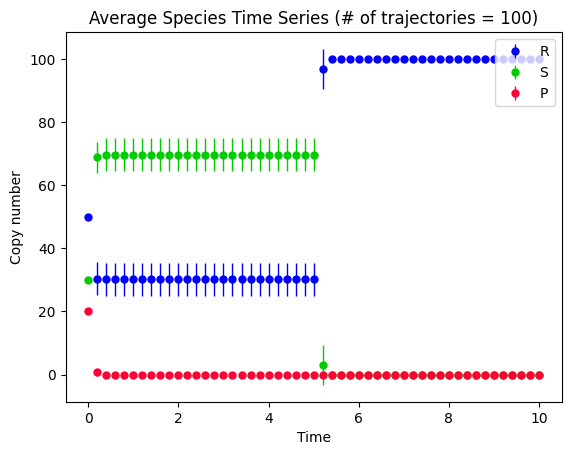

In [42]:
smod.SetDelayParameters({"R1":("fixed",5)}, nonconsuming_reactions=["R1"])
smod.DoDelayedStochSim(mode="time", end=10, trajectories=100)
smod.PlotAverageSpeciesTimeSeries()

If $R1$ is delayed, after the first five seconds, the system will reach the absorbing state where only species $R$ is present.

Performing a stochastic simulation with equal initial population densities:

Info: Direct method is selected to perform stochastic simulations.
Parsing file: ../long_range_models/RSP_model_reduced.psc
Info: No reagents have been fixed
Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 469 End time 1.0884810590458118
Info: Simulation time 0.00349


/Users/irenetesta/anaconda3/envs/try/lib/python3.11/site-packages/stochpy/modules/Analysis.py:479: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.



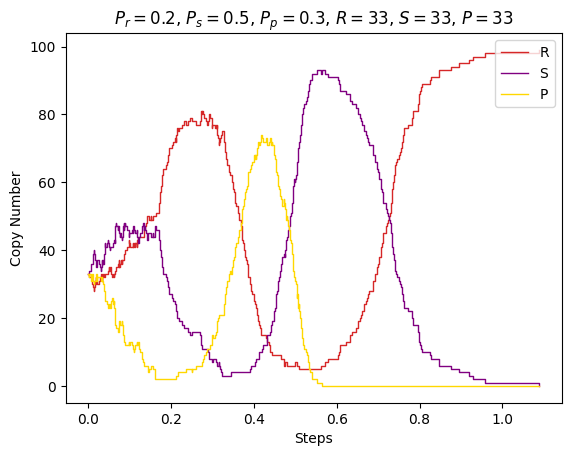

In [43]:
smod.SetDelayParameters({})
smod.ChangeInitialSpeciesCopyNumber("R", 33)
smod.ChangeInitialSpeciesCopyNumber("S", 33)
smod.ChangeInitialSpeciesCopyNumber("P", 33)
smod.DoStochSim(end=1000, method="direct")
smod.PlotSpeciesTimeSeries(colors=["tab:red", "purple", "gold"], xlabel="Steps")
stochpy.plt.title("$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=33$, $S=33$, $P=33$");

Differently from the simulation with ODEs, the system does not exhibit sustained oscillations, as the inherent randomness in the timing and sequence of reactions introduces fluctuations that prevent the emergence of periodic behavior.

## 4. Stochastic model checking

Stochastic model checking enables the verification of properties in stochastic systems by quantifying their probabilities through systematic exploration of all possible system behaviors. 

To perform stochastic model checking we need to translate the model into a Continuous Time Markov Chain (CTMC) and specify the properties we want to verify. Dynamical properties of the resulting CTMC could then be analyzed using the stochastic model checker [PRISM](https://www.prismmodelchecker.org). 

PRISM represents CTMC states using a set of bounded integer variables, necessitating the assumption of a discrete state space. This results in the following CTMC specification in PRISM's input language (stored in the file `../long_range_models/RSP.prism`), where model parameters are defined by `Pr`, `Ps` and `Pp` constants (initialized with the same values used in the previous simulations), `MAX` is the maximum number of molecules per species (set to 100 due to the prohibitive computational time required for higher values) and we have three transitions describing the three possible reactions:

In [44]:
!cat ../long_range_models/RSP.prism

ctmc

const double Pr = 0.2;
const double Ps = 0.5;
const double Pp = 0.3;

const int MAX = 100;

module RSP

  r : [0..MAX] init 50;
  s : [0..MAX] init 30;
  p : [0..MAX] init 20;

  [] r>0 & r<MAX & s>0 -> Pr*r*s : (r'=r+1) & (s'=s-1);
  [] s>0 & s<MAX & p>0 -> Ps*s*p : (s'=s+1) & (p'=p-1);
  [] p>0 & p<MAX & r>0 -> Pp*p*r : (p'=p+1) & (r'=r-1);

endmodule

Noting that `r + s + p = 1`, we can simplify the model to reduce computational time by eliminating the variable `p`. This results in the following PRISM input:

In [45]:
!cat ../long_range_models/RSP_reduced.prism

ctmc

const double Pr = 0.2;
const double Ps = 0.5;
const double Pp = 0.3;

const int MAX = 100;

module RSP

  r : [0..MAX] init 50;
  s : [0..MAX] init 30;

  [] r>0 & r<MAX & s>0 -> Pr*r*s : (r'=r+1) & (s'=s-1);
  [] s>0 & s<MAX & (MAX-r-s)>0 -> Ps*s*(MAX-r-s) : (s'=s+1);
  [] (MAX-r-s)>0 & (MAX-r-s)<MAX & r>0 -> Pp*(MAX-r-s)*r : (r'=r-1);

endmodule

Let's visualize the graphical representation of the CTMC (that can be exported from PRISM) for a system with `MAX=10`:

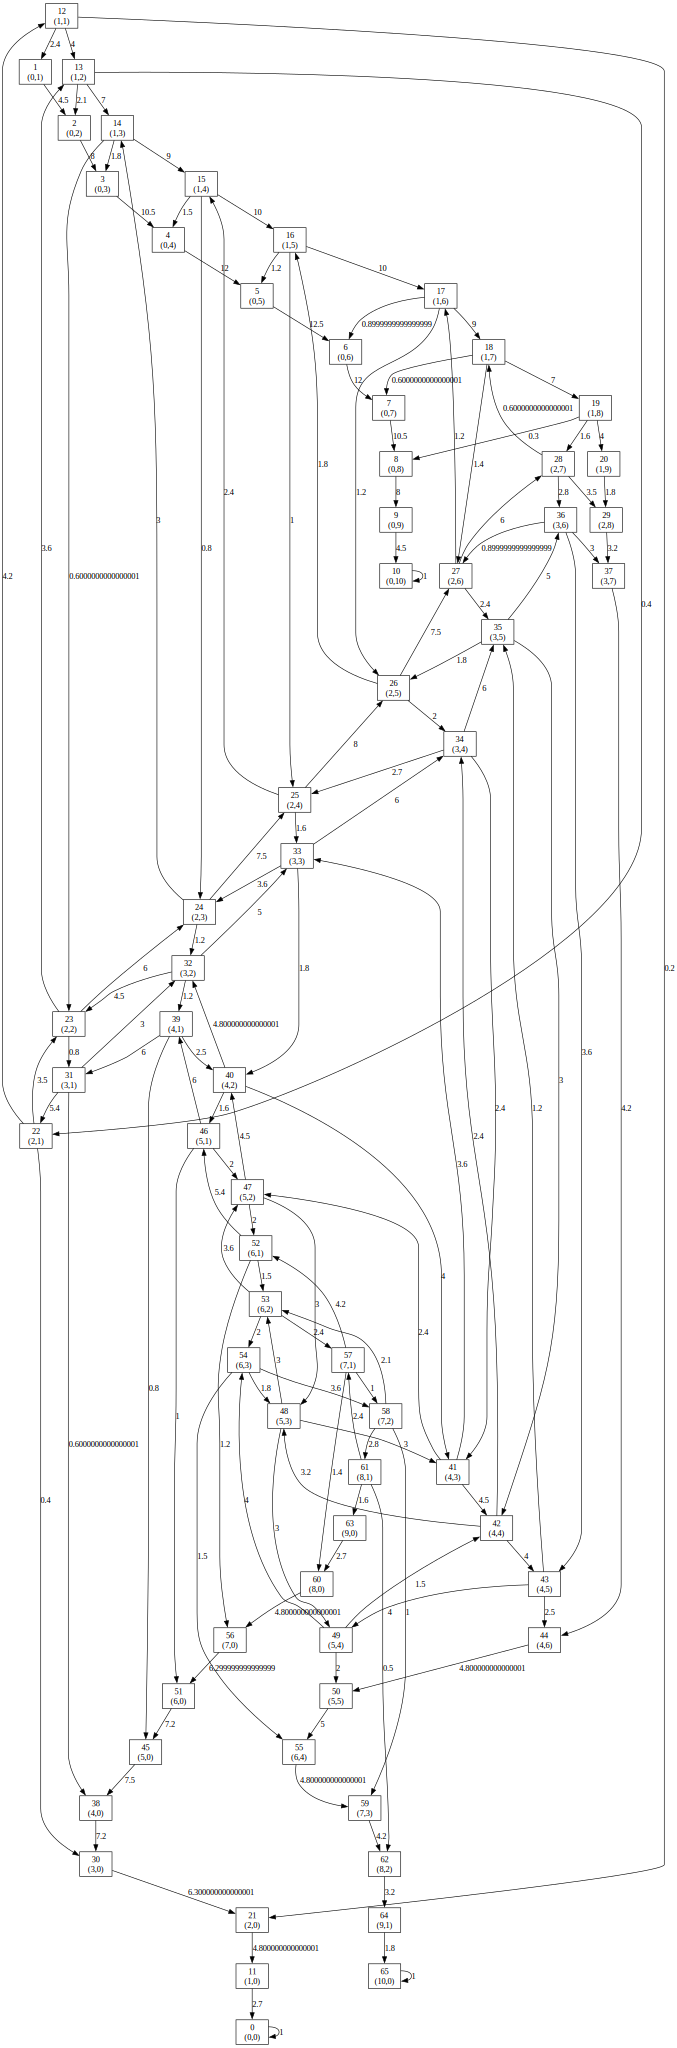

In [46]:
with open('../results/ctmc.dot', 'r') as file:
    dot_data = file.read()
graph = Source(dot_data)
graph


The initial state of the system is state 48, where all exit rates are equal to 3, corresponding to the equilibrium point.

We can define a list of properties to be verified, using the CSL temporal logic:

In [47]:
!cat ../long_range_models/RSP_properties.csl

P=?[ F r=0 ]

P=?[ F s=0 ]

P=?[ F (MAX-r-s)=0 ]

P=?[ F (r=70 & (F r=0)) ]

P=?[ F (s=70 & (F s=0)) ]

P=?[ F ((MAX-r-s)=70 & (F (MAX-r-s)=0)) ]

P=?[ F (MAX-r-s)=0 & s=0 ]

P=?[ F s=0 & r=0 ]

P=?[ F r=0 & (MAX-r-s)=0 ]

const int time;

P=? [ F<time r=0 ]

P=? [ F<time s=0 ]

P=? [ F<time (MAX-r-s)=0 ]

P=? [F<time (r=0 | r=MAX | s=0) & (s=0 | s=MAX | (MAX-r-s)=0) & ((MAX-r-s)=0 | (MAX-r-s)=MAX | r=0)]

const int x;

P=? [ F=1 r>=x & r<x+10 ]

P=? [ F=1 s>=x & s<x+10 ]

P=? [ F=1 (MAX-r-s)>=x & (MAX-r-s)<x+10 ]

and then use PRISM to verify these properties. PRISM saves the results in a log file, which we can load and analyze:

In [48]:
!sed -n '9,128p' ../results/prism_log.txt

Type:        CTMC
Modules:     RSP
Variables:   r s

---------------------------------------------------------------------

Model checking: P=? [ F r=0 ]

Building model...

Computing reachable states...

Reachability (BFS): 121 iterations in 0.00 seconds (average 0.000000, setup 0.00)

Time for model construction: 0.124 seconds.


Type:        CTMC
States:      5151 (1 initial)
Transitions: 14853

Rate matrix: 44090 nodes (3611 terminal), 14853 minterms, vars: 14r/14c

Diagonals vector: 7997 nodes (2482 terminal), 5151 minterms
Embedded Markov chain: 72269 nodes (13625 terminal), 14853 minterms

Prob0: 100 iterations in 0.03 seconds (average 0.000310, setup 0.00)

Prob1: 99 iterations in 0.06 seconds (average 0.000626, setup 0.00)

yes = 200, no = 100, maybe = 4851

Computing remaining probabilities...
Engine: Hybrid

Building hybrid MTBDD matrix... [levels=14, nodes=72180] [3.3 MB]
Adding explicit sparse matrices... [levels=14, num=1, compact] [168.3 KB]
Creating vector for diagonals

By inspecting the log file, we can see that the model has $5151$ states and $14853$ transitions.

The probabilities of extinction for species `r`, `s`, and `p` are $0.14$, $0.98$, and $0.87$, respectively. Again, the population with the lowest invasion rate is the least likely to become extinct.

Loading subsequent lines of PRISM log file:

In [49]:
!sed -n '128,278p' ../results/PRISM_log.txt

---------------------------------------------------------------------

Model checking: P=? [ F (r=70&(F r=0)) ]

Building deterministic automaton (for F ("L0"&(F "L1")))...
DFA has 3 states, 1 goal states.
Time for deterministic automaton translation: 0.03 seconds.

Constructing MC-DFA product...

Reachability (BFS): 181 iterations in 0.05 seconds (average 0.000260, setup 0.00)

States:      9806 (1 initial)
Transitions: 28340

Transition matrix: 44164 nodes (3611 terminal), 28340 minterms, vars: 16r/16c

Skipping BSCC computation since acceptance is defined via goal states...

Computing reachability probabilities...

Diagonals vector: 8037 nodes (2485 terminal), 9806 minterms
Embedded Markov chain: 72343 nodes (13625 terminal), 28340 minterms

Prob0: 208 iterations in 0.06 seconds (average 0.000303, setup 0.00)

Prob1: 99 iterations in 0.11 seconds (average 0.001101, setup 0.00)

yes = 200, no = 339, maybe = 9267

Computing remaining probabilities...
Engine: Hybrid

Building hybrid MT

The probability of a species to go extinct after having reached a density of $0.7$ is $0.14$ for species `r`, $0.65$ for species `s`, and $0.29$ for species `p`. If species `s`and `p` reach a density of $0.7$, they are less likely to become extinct in the future as compared to the extinction probability of these species from the initial state.

Loading subsequent lines of PRISM log file:

In [50]:
!sed -n '278,375p' ../results/PRISM_log.txt

---------------------------------------------------------------------

Model checking: P=? [ F s=0&r=0 ]

Diagonals vector: 7997 nodes (2482 terminal), 5151 minterms
Embedded Markov chain: 72269 nodes (13625 terminal), 14853 minterms

Prob0: 198 iterations in 0.05 seconds (average 0.000237, setup 0.00)

Prob1: 50 iterations in 0.01 seconds (average 0.000300, setup 0.00)

yes = 100, no = 200, maybe = 4851

Computing remaining probabilities...
Engine: Hybrid

Building hybrid MTBDD matrix... [levels=14, nodes=72180] [3.3 MB]
Adding explicit sparse matrices... [levels=14, num=1, compact] [168.3 KB]
Creating vector for diagonals... [dist=1, compact] [10.1 KB]
Creating vector for RHS... [dist=2, compact] [10.1 KB]
Allocating iteration vectors... [2 x 40.2 KB]
TOTAL: [3.6 MB]

Starting iterations...

Jacobi: 5060 iterations in 2.31 seconds (average 0.000015, setup 2.23)

Value in the initial state: 0.12484498983774625

Time for model checking: 5.309 seconds.

Result: 0.12484498983774625 (+/- 

The probability that each species will outcompete the other two (corresponding to an absorbing state, i.e. a state where no further transitions are possible) is $0.12$ for species `p`, $0.02$ for species `s`, and $0.86$ for species `r`.

By varying the constant `time` between $1$ and $10$, we can plot the extinction probabilities for each species, i.e.:
```
const int time;
P=? [ F<time r=0 ]
P=? [ F<time s=0 ]
P=? [ F<time (MAX-r-s)=0 ]
```

<img align="center" src='../results/extintion_fixed.png' width="600px">

Rock, the species with the lowest invasion rate, is the most likely to survive. This result is due to the finiteness of the populations, which prevents the system to remain at the fixed point.

We can also plot the probability of reaching any absorbing state within the first $6$ time units, i.e.:
```
const int time;
P=? [F<time (r=0 | r=MAX | s=0) & (s=0 | s=MAX | (MAX-r-s)=0) & ((MAX-r-s)=0 | (MAX-r-s)=MAX | r=0)]
```

<img align="center" src='../results/absorbing_state.png' width="600px">

After 5 time steps, the system reaches an absorbing state with certainty.

By binning the number of individuals in disjoint intervals ($x <= \text{number of individuals} < x+10$), we can plot the probabilities for each species being in a certain interval at time $t=1$, i.e.:
```
const int x;
P=? [ F=1 r>=x & r<x+10 ]
P=? [ F=1 s>=x & s<x+10 ]
P=? [ F=1 (MAX-r-s)>=x & (MAX-r-s)<x+10 ]
```

<img align="center" src='../results/individuals_fixed.png' width="600px">

After a time step, the probability mass of species `s` and `p` is concentrated at lower values, while species `r` has a more uniform distribution.

PRISM can also be used to conduct stochastic simulations. For example, here is a simulation of the system where, similar to the simulation performed with `StochPy`, species `r` is the only one to survive.

<img align="center" src='../results/prism_simulation.png' width="600px">

## 5. Petri net analysis

A graphical representation of a system of chemical reaction can also be given in terms of Petri nets. Several variants of Petri nets exist, here we consider stochastic Petri nets, a variant that allows the modeling of stochastic systems.

For the rock-scissors-paper model, analyzing the net through property verification is relatively straightforward and doesn't provide substantial insights. However, we will carry out this verification as a tutorial to illustrate the step-by-step approach to modeling and analyzing more complex biochemical networks.

The Petri net representing the system was created using the [Snoopy tool](https://www-dssz.informatik.tu-cottbus.de/DSSZ/Software/Snoopy), saved as `./long_range_models/rsp.spn`, and subsequently imported into the [Charlie tool](https://www-dssz.informatik.tu-cottbus.de/DSSZ/Software/Charlie) for analysis.

Let's introduce some definitions, necessary for the analysis of the Petri net.

A Stochastic Petri net consists of places, transitions with corresponding kinetic functions, arcs and tokens. Places represent the species, transitions represent the reactions, arcs represent the flow of species between reactions and tokens represent the number of molecules of each species. The distribution of the tokens in the places is formalized by the notion of marking.

More formally, a stochastic Petri net is a quintuple $N = (P, T, f, \nu, m_0)$, where

- $P$ and $T$ are finite, non empty, and disjoint sets. $P$ is the set of places (in the figures represented by circles). $T$ is the set of transitions (in the figures represented by rectangles);
- $f : ((P \times T)\cup (T \times P)) \rightarrow \mathbb{N}_0$ defines the set of directed arcs, weighted by nonnegative integer values;
- $\nu:T \rightarrow \Psi$, with $\Psi=M\rightarrow R\geq 0$, is a function that assigns to each transition a function corresponding to the computation of a kinetic formula to every possible marking $m \in M$;
- $m_0 \in M: P \rightarrow \mathbb{N}_0$ gives the initial marking.

The stochastic Petri net for the rock-paper-scissor system is shown below, where we set the initial marking $P=20, R=50, S=30$ and made the kinetic functions correspond to the law of mass action with constants equal to the invasion rates $P_r=0.2$, $P_s=0.5$ and $P_p=0.3$:

<img align="center" src='../results/petri_net.png' width="200px">

The **preset of a node** $x\in P \cup T$ is defined as $•x:=\{y\in P\cup T |f(y,x) \neq 0\}$, and its post set as $x• :=\{y\in P \cup T| f(x,y) \neq 0\}$. Altogether we get four types of sets:
- $•t$, the **preplaces** of a transition $t$, consisting of the reaction’s precursors
- $t•$, the **postplaces** of a transition $t$, consisting of the reaction’s products
- $•p$, the **pretransitions** of a place $p$, consisting of all reactions producing this species
- $p•$, the **posttransitions** of a place $p$, consisting of all reactions consuming this species

Given a set of places $S=p_1, p_2, \ldots$, the pre-transition of a set of places $S$ is defined as $•S=•p_1 \cup •p_2 \cup \ldots$, while the post-transition of a set of places $S$ is defined as $S•=p_1• \cup p_2• \cup \ldots$.

In this particular net, the pretransition and posttransition of the sites are as follows:
- $•P=\{Pp\}$
- $•R=\{Pr\}$
- $•S=\{Ps\}$
- $P•=\{Pp,Ps\}$
- $R•=\{Pr,Pp\}$
- $S•=\{Ps,Pr\}$

The **incidence matrix** of $\mathcal{N}$ is a matrix $C:P\times T \rightarrow \mathbb{Z}$, indexed by $P$ and $T$, such that $C(p,t)=f(t,p)−f(p,t)$.

Loading the file containing the incidence matrix produced by Charlie:

In [51]:
!cat ../results/petri_net_incidence_matrix.txtm

placeNames = {P R S };
transitionNames = {Pp Pr Ps };
C=[
1 0 -1 ;
-1 1 0 ;
0 -1 1 ;
];


We can easily verify that it is obtained by
$$C = \begin{bmatrix}
2 & 0 & 0 \\
0 & 2 & 0 \\
0 & 0 & 2
\end{bmatrix}
-
\begin{bmatrix}
1 & 0 & 1 \\
1 & 1 & 0 \\
0 & 1 & 1
\end{bmatrix}$$

and we can compute its rank (which is necessary to determine if certain properties of the net hold, as discussed later) as follows:

In [52]:
C = Matrix([[1, 0, -1], [-1, 1, 0], [0, -1, 1]])
rank = C.rank()
rank

2

A **place vector** (**transition vector**) is a vector $x : P \rightarrow \mathbb{Z}$, indexed by $P$ ($y : T \rightarrow \mathbb{Z}$, indexed by $T$).

A place vector (transition vector) is called a **P-invariant** (**T-invariant**) if it is a nontrivial nonnegative integer solution of the linear equation system $x \cdot C = 0$ ($C \cdot y = 0$). 

If $p$ is a P-invariant, then the weighted sum of tokens across the places (using the weights specified by the p-invariant) is preserved under the firing of transitions.
If $t$ is a T-invariant, then if you fire the transitions according to the vector $t$ (where the number of times each transition is fired is given by the corresponding entry in $t$), the net's marking will remain unchanged.

Computing P-invariants:

In [53]:
x1, x2, x3 = symbols('x1 x2 x3')
x = Matrix([x1, x2, x3])
equation = Eq(x.T * C, Matrix([[0, 0, 0]]))
solution = solve(equation, (x1, x2, x3), dict=True)
solution

[{x1: x3, x2: x3}]

Any vector of the form $[x,x,x]$ is a place invariant. In fact it is trivial that the sum of the number of tokens in the places is constant (equal to $100$).

Checking the file containing the P-invariants computed by Charlie:

In [54]:
!cat ../results/rsp_P.inv

minimal semipositive place invariants=
1	|	0.P		:1,
	|	1.R		:1,
	|	2.S		:1


The vector $[1, 1, 1]$ is a P-invariant for any multiplicative constants.

Computing T-invariants:

In [55]:
y1, y2, y3 = symbols('y1 y2 y3')
y = Matrix([y1, y2, y3])
equation = Eq(C * y, Matrix([[0, 0, 0]]).T)
solution = solve(equation, (y1, y2, y3), dict=True)
solution

[{y1: y3, y2: y3}]

Any vector of the form $[y,y,y]$ is a transition invariant. In fact it is trivial that applying the three transitions an equal number of times will not change the marking of the net.

Checking the file containing the T-invariants computed by Charlie:

In [56]:
!cat ../results/rsp_T.inv

minimal semipositive transition invariants=
1	|	0.Pp		:1,
	|	1.Pr		:1,
	|	2.Ps		:1


The vector $[1, 1, 1]$ is a P-invariant for any multiplicative constants.

All markings, which can be reached from a given marking $m$ by any firing sequence of arbitrary length, constitute the set of **reachable markings** $[m⟩$. For this specific net, the set of reachable markings is straightforward to compute: it consists of all possible triples of elements less than $100$ that sum to $100$.

A **transition** t is **dead** in the marking m if it is not enabled in any marking $m^{\prime}$ reachable from m: $\nexists m^{\prime} \in [m⟩ : m^{\prime}[t⟩$. A **transition** t is **live** if it is not dead in any marking reachable from $m_0$.

A **marking** $m$ is **dead** if there is no transition which is enabled in $m$.

A nonempty set of places $D \subseteq P$ is called **siphon** if $•D \subseteq D•$ (the set of pretransitions is contained in the set of posttransitions), i.e. every transition which fires tokens onto a place in this structural deadlock set, also has a preplace in this set.

In this particular net, we have:
- $•\{P\} = \{Pp\} \subseteq \{P\}•=\{Pp, Ps\} \implies \{P\}$ is a siphon
- $•\{R\} = \{Pr\} \subseteq \{R\}•=\{Pr, Pp\} \implies \{R\}$ is a siphon
- $•\{S\} = \{Ps\} \subseteq \{S\}•=\{Ps, Pr\} \implies \{S\}$ is a siphon
- $•\{R,S\}=\{Pr, Ps\} \subseteq \{R,S\}•=\{Pr, Pp, Ps\} \implies \{R,S\}$ is a siphon
- $•\{P, R\} = \{Pp, Pr\} \subseteq \{P, R\}• = \{Pp, Ps, Pr\} \implies \{P, R\}$ is a siphon
- $•\{P, S\} = \{Pp, Ps\} \subseteq \{P, S\}• = \{Pp, Ps, Pr\} \implies \{P, S\}$ is a siphon
- $•\{P, R, S\} = \{Pp, Pr, Ps\} = \{P, R, S\}• = \{Pp, Pr, Ps\} \implies \{P, R, S\}$ is a siphon

Once a siphon becomes empty (i.e., contains no tokens), it cannot be refilled with tokens by the firing of any transitions (i.e. such part of the system becomes permanently disabled). This means that once a species (or a couple of species) goes extinct, it cannot be reintroduced in the system.

A siphon is minimal if it does not properly contain a non-empty siphon.

In this particular net, $\{P\}, \{R\}, \{S\}$ are minimal siphons.

Checking the file containing the minimal siphons computed by Charlie:

In [57]:
!cat ../results/rsp_DLS.res

 minimal proper siphon ( place )= 

1	|0.P	:1
2	|1.R	:1
3	|2.S	:1
@

1| siphon_1| minimal siphon_1
2| siphon_2| minimal siphon_2
3| siphon_3| minimal siphon_3

A set of places $Q \subseteq P$ is called **trap** if $Q• \subseteq •Q$ (the set of posttransitions is contained in the set of pretransitions), i.e. every transition which subtracts tokens from a place of the trap set, also has a postplace in this set.

In this particular net, we have:
- $\{P\}•=\{Pp, Ps\} \nsubseteq •\{P\} = \{Pp\}\implies \{P\}$ is not a trap
- $\{R\}•=\{Pr, Pp\} \nsubseteq •\{R\} = \{Pr\} \implies \{R\}$ is not a trap
- $\{S\}•=\{Ps, Pr\} \nsubseteq •\{S\} = \{Ps\} \implies \{S\}$ is not a trap
- $\{R,S\}•=\{Pr, Pp, Ps\} \nsubseteq •\{R,S\}=\{Pr, Ps\} \implies \{R,S\}$ is not a trap
- $\{P, R\}• = \{Pp, Ps, Pr\} \nsubseteq •\{P, R\} = \{Pp, Pr\} \implies \{P, R\}$ is not a trap
- $\{P, S\}• = \{Pp, Ps, Pr\} \nsubseteq •\{P, S\} = \{Pp, Ps\} \implies \{P, S\}$ is not a trap
- $\{P, R, S\}• = \{Pp, Pr, Ps\} = •\{P, R, S\} = \{Pp, Pr, Ps\} \implies \{P, R, S\}$ is a trap

A trap is minimal if it does not properly contain a non-empty trap.

In this particular net, $\{P, R, S\}$ is a minimal trap.

Checking the file containing the minimal traps computed by Charlie:

In [58]:
!cat ../results/rsp_TPS.res

 minimal traps ( place )= 

1	|0.P	:1,
	|1.R	:1,
	|2.S	:1

The "Net Properties" dialog in Charlie provides an overview of the key properties of the net. For this particular net, they are shown below:

<img align="center" src='../results/petri_net_props.png' width="400px">

The properties are described in the following Table (sourced from [[3]](#6-references)).

| Abbreviation | Name                                     | Description                                | Status   |
|--------------|------------------------------------------|--------------------------------------------|----------|
| PUR          | pure                                     | $\forall x, y \in P \cup T : f (x, y) \neq 0 \implies f (y, x) = 0$, i.e. there are no two nodes, connected in both directions. This precludes read arcs. Then the net structure is fully represented by the incidence matrix, which is used for the calculation of the P- and T-invariants. | ❌ |
| ORD          | ordinary                                 |  $\forall x, y \in P \cup T : f (x, y) \neq 0 \implies f (x, y) = 1$, i.e. all arc weights are equal to 1. This includes homogeneity. A non-ordinary Petri net cannot be live and 1-bounded at the same time. |  ❌ |
| HOM          | homogeneous                              |  $\forall p \in P :t,t^{\prime} \in p• \implies f(p,t)=f(p,t^{\prime})$, i.e. all outgoing arcs of a given place have the same multiplicity.  |  ✅ |
| NBM          | non blocking multiplicity                |  A net has non-blocking multiplicity if $\forall p \in P :•p \neq \emptyset \land min\{f(t,p)\vert \forall t \in •p\}\geq max\{f(p,t)\vert \forall t \in p•\}$, i.e. an input place causes blocking multiplicity. Otherwise, it must hold for each place: the minimum of the multiplicities of the incoming arcs is not less than the maximum of the multiplicities of the outgoing arcs. |  ✅ |
| CSV          | conservative                             |  A Petri net is conservative if $\forall t \in T : \sum_{p \in •t} f(p,t) = \sum_{p \in t•} f(t,p)$ i.e. all transitions add exactly as many tokens to their postplaces as they subtract from their preplaces, or briefly, all transitions fire token-preservingly. A conservative Petri net is structurally bounded.  |  ✅ |
| SCF          | structurally conflict free               |  A Petri net is static (or structurally) conflict free if $\forall t,t^{\prime} \in T :t \neq t^{\prime} \implies •t \cap •t^{\prime} = \emptyset$, i.e. there are no two transitions sharing a preplace. Transitions involved in a static conflict compete for the tokens on shared preplaces. Thus, static conflicts indicate situations where dynamic conflicts, i.e. nondeterministic choices, may occur in the system behaviour. However, it depends on the token situation whether a conflict does actually occur dynamically. There is no nondeterminism in SCF nets.  |  ❌ |
| FT0          | every transition has a pre-place         |  $\forall t: •t \neq \emptyset$  |  ✅ |
| TF0          | every transition has a post-place        |  $\forall t: t• \neq \emptyset$  |  ✅ |
| FP0          | every place has a pre-transition         |  $\forall p: •p \neq \emptyset$  |  ✅ |
| PF0          | every place has a post-transition        |  $\forall p: p• \neq \emptyset$  |  ✅ |
| CON          | connected                                |  A Petri net is connected if it holds for every two nodes $a$ and $b$ that there is an undirected path between $a$ and $b$. Disconnected parts of a Petri net cannot influence each other, so they can usually be analysed separately. |  ✅ |
| SC           | strongly connected                       |  A Petri net is strongly connected if it holds for every two nodes $a$ and $b$ that there is a directed path from $a$ to $b$. Strong connectedness involves connectedness and the absence of boundary nodes. It is a necessary condition for a Petri net to be live and bounded at the same time.  |  ✅ |
| NC           | netclass                                 |  The net structure class: 1) A Petri net is called State Machine (SM) if $\forall t\in T :\vert •t \vert =\vert t•\vert \leq 1$, i.e. there are neither forward branching nor backward branching transitions. 2) A Petri net is called Synchronisation Graph (SG) if $\forall p\in P :\vert •p\vert =\vert p•\vert \leq 1$, i.e. there are neither forward branching nor backward branching places. 3) A Petri net is called Extended Free Choice (EFC) if $\forall p,q\in P:p• ∩q• =\emptyset \lor p• =q•$, i.e. transitions in conflict have identical sets of preplaces. 4) A Petri net is called Extended Simple (ES) if $\forall p,q\in P:p• \cap q• =\emptyset \lor p• \subseteq q• \lor q• \subseteq p•$, i.e. every transition is involved in one conflict at most. 5) If the net does not comply to any of the introduced net structure classes, it is said to be not Extended Simple (nES). | nES |
| RKTH         | rank theorem                             |  $rank(IM) \neq \vert SCCS\vert - 1 \implies !RKTH$, i.e. if the rank of the incidence matrix is not equal to the number of strongly connected components (maximal sets of strongly connected nodes) minus one, then the rank theorem does not hold.  |  ❌ |
| STP          | siphon trap property                     | The siphon trap property holds if no siphons are bad. A siphon is called bad if it does not include a trap. |  ❌ |
| CPI          | covered by P-invariants                  |  A net is covered by P-invariants, shortly CPI, if every place belongs to a P-invariant.  |  ✅ |
| CTI          | covered by T-invariants                  |  A net is covered by T-invariants, shortly CTI, if every transition belongs to a T-invariant.  |  ✅ |
| SCTI         | strongly covered by T-invariants         | The two transitions modelling the two directions of a reversible reaction always make a minimal T-invariant and they are called trivial T-invariants. A net which is covered by nontrivial T-invariants is said to be strongly covered by T-invariants. | ✅ |
| SB           | structurally bounded                     |  A net is structurally bounded if it is bounded for any initial marking  |  ✅ |
| k-B          | k-bounded                                |  A place $p$ is k-bounded (bounded for short) if there exists a positive integer number $k$, which represents an upper bound for the number of tokens on this place in all reachable markings of the Petri net: $\exists k \in \mathbb{N}_0 :\forall m\in [m_0⟩:m(p)\leq k$. A Petri net is k-bounded (bounded for short) if all its places are k-bounded. | 100 |
| DCF          | dynamically conflict free                |  Dynamic conflict is a behavioural property which refers to a marking enabling two transitions, but the firing of one transition disables the other one. The occurrence of dynamic conflicts causes alternative (branching) system behaviour, whereby the decision between these alternatives is taken nondeterministically.  |  ❌ |
| DSt          | no dead state(s)                         | True if the net does not have dead states (markings). |  3 |
| DTr          | no dead transition(s)                    | If the net does not have dead transitions at the initial state.  |  ✅ |
| LIV          | live                                     | A Petri net is live (strongly live) if each transition is live. |  ❌ |
| REV          | reversible                               |  A Petri net is reversible if the initial marking can be reached again from each reachable marking: $\forall m \in [m_0⟩ : m_0 \in [m⟩$ |  ❌ |

Charlie checks these properties by applying a set of rules, as shown in the log file generated by the tool:

In [59]:
!cat ../results/charlie_log.txt


starts analysis with following options:
charlie.analyzer.structural.StructuralOptionSet

number of places: 3
number of transitions: 3
number of arcs: 9

input places:
no input places
output places:
no output places
input transitions:
no input transitions
output transitions:
no output transitions

Structural coupled conflict sets: 

1	|0.Pp	:1,
	|1.Pr	:1,
	|2.Ps	:1
 
Structural equal conflict sets: 

1	|0.Pp	:1
2	|1.Pr	:1
3	|2.Ps	:1
 
time:  0 m 0 s



Applying rule:
CSV => k-B


Applying rule:
CSV => SB


Applying rule:
SC => CON


Applying rule:
CSV => CPI


Applying rule:
CPI => k-B


Applying rule:
SB => k-B


Applying rule:
CPI => SB

Analyzer: Rank of Matrix Analyzer
start time: 19/08/24, 15:09
starts analysis with following options:
charlie.analyzer.invariant.RankIncidenceMatrixOptionSet
Rank of the incidence matrix: 2
time: 00:00:00:013



Applying rule:
rank(IM) != |SCCS| - 1 => !RKTH

Analyzer: Structurally Bounded Analyzer
start time: 19/08/24, 15:09
starts analysis with fol

Since a stochastic Petri net can be translated into a CTMC, Charlie provides the possibility to export the net in the PRISM input language. Let's check whether the PRISM model produced by Charlie corresponds to the one we manually created:

In [60]:
!cat ../long_range_models/rsp.sm

//created by Snoopy 2
//date: Sun Aug 18 14:58:29 2024

ctmc

const int Max;
const int N;
module  rsp

S:  [ 0..Max ]  init 30*N;
R:  [ 0..Max ]  init 50*N;
P:  [ 0..Max ]  init 20*N;


[Pp]
(P > 0) & (R > 0)
 -> (0.3) * P * R : 
(P' = P+1) & (R' = R-1);


[Pr]
(R > 0) & (S > 0)
 -> (0.2) * R * S : 
(R' = R+1) & (S' = S-1);


[Ps]
(P > 0) & (S > 0)
 -> (0.5) * S * P : 
(P' = P-1) & (S' = S+1);





endmodule


Aside from the missing constraints on the variables' maximum values, the model is identical to the one we manually created.

## 6. References

- [1] Frean, Marcus, and Edward R. Abraham. "Rock–scissors–paper and the survival of the weakest." Proceedings of the Royal Society of London. Series B: Biological Sciences 268.1474 (2001): 1323-1327.
- [2] Weissing, Franz J. "Evolutionary stability and dynamic stability in a class of evolutionary normal form games." Game equilibrium models I: evolution and game dynamics. Berlin, Heidelberg: Springer Berlin Heidelberg, 1991. 29-97.
- [3] Heiner, Monika, David Gilbert, and Robin Donaldson. "Petri nets for systems and synthetic biology." International school on formal methods for the design of computer, communication and software systems. Berlin, Heidelberg: Springer Berlin Heidelberg, 2008. 215-264.